In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import random
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:
import wandb

api = wandb.Api()
entity, project, run_id = "psotoarenas", "DynamicSIM-RL", "2ogti48e"

def get_log(entity, project, run_id):
    run = api.run(entity + "/" + project + "/" + run_id)
    if run.state == "finished":
        print(f"Querying {run.name} with run_id {run.id}")
        root = os.path.join("./logs/", run.id)
        for file in run.files():
            if file.name.startswith("python") and file.name.endswith("traces"):
                logs = file.name
                print(f"Logs found with name {logs}")
        if not logs:
            logs = "output.log"
            print(f"No logs found. Downloading default logs {logs}")
        run.file(logs).download(root=root, replace=True)
        log_old_filename = os.path.join(root, logs)
        log_new_filename = os.path.join(root, f"{run.config['mode']}.traces")
        print(f"Saving train logfile to {log_new_filename}")
        os.rename(log_old_filename, log_new_filename)
    else: 
        print(f"Run with id {run_id} has not finished yet")
    return run.id

test_run_id = get_log(entity=entity, project=project, run_id=run_id)
print(f"Test ID: {test_run_id}")

Querying absurd-pyramid-177 with run_id 2ogti48e
Logs found with name python-20211116-163842.traces
Saving train logfile to ./logs/2ogti48e/test.traces
Test ID: 2ogti48e


In [3]:
root_folder = "./logs"
os.chdir(os.path.join(root_folder, run_id))
test_traces = "test.traces"

In [4]:
# Parse Results
# initialize dicts
modes = ["testing"]
jobs = {key: [] for key in modes}
ms = {key: [] for key in modes}
cpu_usage = {key: [] for key in modes}
overflow = {key: [] for key in modes}
peak_latency = {key: [] for key in modes}
avg_latency = {key: [] for key in modes}
action = {key: [] for key in modes}
reward = {key: [] for key in modes}
cum_reward = {key: [] for key in modes}
reward_cum = {key: [] for key in modes}
current_timesteps = {key: [] for key in modes}
restarts_per_episode = {key: {} for key in modes}
timesteps = {}

act_2_meaning = {
    0: "increase",
    1: "decrease",
    2: "nothing"
}
# Parse results
print(test_traces)
with open(test_traces) as f:
    current_step = 0
    cumulative_reward = 0
    for line in f:
        line = line.rstrip().split("|")[-1]
        if line.startswith("Mode"):
            mode = line.split(":")[-1].rstrip().split()[0]
            timesteps[mode] = int(line.split(":")[-1].rstrip().split()[2])
            if mode == "training": timesteps["base"] = int(line.split(":")[-1].rstrip().split()[-2])
        if line.startswith("Step"):
            current_step = int(line.split(":")[-1].rstrip())
            current_timesteps[mode].append(current_step)
        if line.startswith("Environment Reset"):
            if not restarts_per_episode[mode]:
                # dict is empty
                restarts_per_episode[mode] = []
            if current_step != 0:
                # if it is not the first step
                restarts_per_episode[mode].append(current_step)
                cum_reward[mode].append(cumulative_reward)
        if line.startswith("Traffic"):
            jobs[mode].append(int(line.split(":")[-1].rstrip()))
        if line.startswith("MS"):
            ms[mode].append(int(line.split(":")[-1].rstrip()))
        if line.startswith("Cpu"):
            cpu_usage[mode].append(float(line.split(":")[-1].rstrip()))
        if line.startswith("Overflow"):
            overflow[mode].append(float(line.split(":")[-1].rstrip()))
        if line.startswith("Peak Latency"):
            peak_latency[mode].append(float(line.split(":")[-1].rstrip()))
        if line.startswith("Avg Latency"):
            avg_latency[mode].append(float(line.split(":")[-1].rstrip()))
        if line.startswith("Reward"):
            reward[mode].append(float(line.split(":")[-1].rstrip()))
        if line.startswith("Cum Reward"):
            cumulative_reward = float(line.split(":")[-1].rstrip())
            reward_cum[mode].append(float(line.split(":")[-1].rstrip()))
        if line.startswith("Action"):
            line = line.split(",")[0]
            action[mode].append(act_2_meaning[int(line.split(":")[-1].rstrip())])
        if line.startswith("Agent end training"):
            print(line)
            
cum_reward["testing"].append(cumulative_reward)
restarts_per_episode["testing"].append(current_step)

test.traces


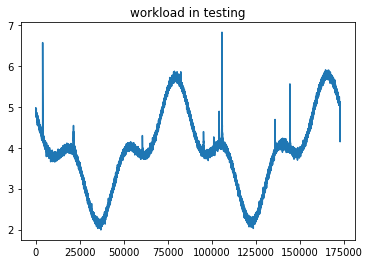

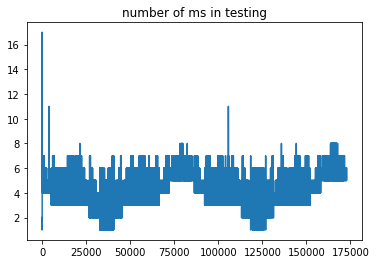

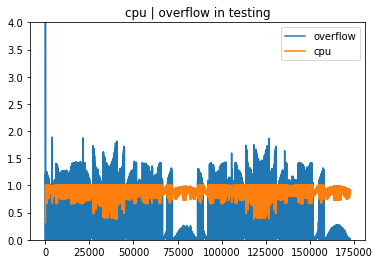

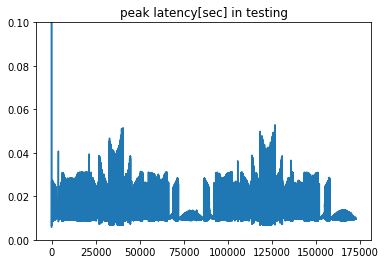

In [5]:
# test figures
# --------------- workload ------------------------------
plt.figure()
plt.plot(np.array(jobs["testing"])/300.)
plt.title("workload in testing")
plt.savefig('./workload_test.pdf', dpi=300)
plt.show()

# --------------- num ms ------------------------------
plt.figure()
plt.plot(np.array(ms["testing"]))
plt.title("number of ms in testing")
plt.savefig('./ms_test.pdf', dpi=300)
plt.show()

# --------------- cpu|overflow ------------------------------
plt.figure()
plt.plot(np.array(overflow["testing"]), label="overflow")
plt.plot(np.array(cpu_usage["testing"]), label="cpu")
plt.ylim([0, 4])
plt.title("cpu | overflow in testing")
plt.legend()
plt.savefig('./cpu_overflow_test.pdf', dpi=300)
plt.show()

# --------------- peak latency ------------------------------
plt.figure()
plt.plot(np.array(peak_latency["testing"]))
plt.ylim([0, 0.1])
plt.title("peak latency[sec] in testing")
plt.savefig('./peak_latency_test.pdf', dpi=300)
plt.show()

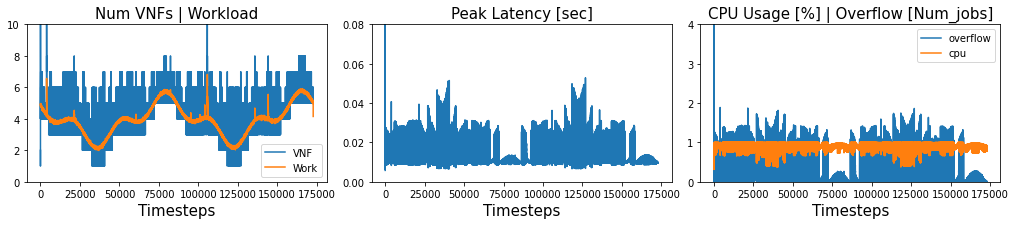

In [6]:
# plots for paper
fontsize=15

fig = plt.figure(constrained_layout=True, figsize=(14,3))
gs = GridSpec(1, 3, figure=fig)
# 
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(np.array(ms["testing"]), label='VNF')
ax1.plot(np.array(jobs["testing"])/300., label='Work')
ax1.set_ylim([0, 10])
ax1.set_xlabel('Timesteps', fontsize=fontsize)
ax1.set_title('Num VNFs | Workload', fontsize=fontsize)
ax1.legend()
# 
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(np.array(peak_latency["testing"]), label='peak_lat')
ax2.set_ylim([0, 0.08])
ax2.set_xlabel('Timesteps', fontsize=fontsize)
ax2.set_title('Peak Latency [sec]', fontsize=fontsize)
# 
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(np.array(overflow["testing"]), label='overflow')
ax3.plot(np.array(cpu_usage["testing"]), label='cpu')
ax3.set_ylim([0, 4])
ax3.set_xlabel('Timesteps', fontsize=fontsize)
ax3.set_title('CPU Usage [%] | Overflow [Num_jobs]', fontsize=fontsize)
ax3.legend()

plt.savefig('./results_thd_paper.pdf', dpi=300)
plt.show()

In [7]:
# statistics
df = pd.DataFrame({'num_ms': ms["testing"], 'peak_latency': peak_latency["testing"]})
print(df.describe())

              num_ms   peak_latency
count  172801.000000  172801.000000
mean        4.327255       0.015280
std         1.249430       0.007065
min         1.000000       0.005810
25%         3.000000       0.009850
50%         4.000000       0.011830
75%         5.000000       0.019500
max        17.000000       0.144020


In [8]:
# SLO Violations
max_latency = 0.024
peak = np.array(peak_latency["testing"])
total_slo_measurements = len(peak)
peak = peak[peak>max_latency]
total_slo_violations = len(peak)
print(f"Total of SLO violations: {total_slo_violations}")
perc_slo_violations = total_slo_violations/total_slo_measurements
print(f"Percentage of SLO violations: {perc_slo_violations:2.2%}")

Total of SLO violations: 21279
Percentage of SLO violations: 12.31%
